In [34]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

# Import netket library
import netket as nk
from netket.operator.spin import sigmaz

# Import Json, this will be needed to load log files
import json

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

In [30]:
L = 4
graph = nk.graph.Hypercube(length=L, n_dim=2, pbc=True)

# Define the Hilbert space based on this graph
# h-J1 model is not spin conserved
hi = nk.hilbert.Spin(s=0.5, N=graph.n_nodes)

In [31]:
hfield = 1.6
J = 1
# calling the Heisenberg Hamiltonian
ha_heisenberg = J * nk.operator.Heisenberg(hilbert=hi, graph=graph)

# creating the B-field hamiltonian
ha_hfield = sum([hfield*sigmaz(hi,i) for i in range(hi.size)])
ha = ha_hfield + ha_heisenberg
#ha = ha_heisenberg

In [32]:
# compute the ground-state energy (here we only need the lowest energy, and do not need the eigenstate)
evals, evecs = nk.exact.lanczos_ed(ha, k = 1, compute_eigenvectors=True)
exact_gs_energy = evals[0]
gs = evecs[:,0]
print('The exact ground-state energy is E0=',exact_gs_energy)


The exact ground-state energy is E0= -45.799539490653764


In [33]:
Szs = sum([sigmaz(hi,i) for i in range(hi.size)])
Szcorr = sum([sigmaz(hi,i)*sigmaz(hi,j) for (i,j) in graph.edges()])

print("The exact value of <Sz> is ", gs @ (Szs @ gs))
print("The exact value of <SzSz> is ", gs @ (Szcorr @ gs))

The exact value of <Sz> is  -2.0000000000000013
The exact value of <SzSz> is  -9.916248368848292


## Jastrow

In [6]:
import flax.linen as nn
import jax.numpy as jnp
import jax

class Jastrow(nn.Module):
    @nn.compact
    def __call__(self, x):
        # sometimes we call this function with a 1D input, sometimes with a 2D.
        # We promote all inputs to 2D to make the following code simpler.
        x = jnp.atleast_2d(x)
        # We vmap along the 0-th axis of the input
        # This will automatically convert a function working on vectors to one working
        # on matrices.
        return jax.vmap(self.evaluate_single, in_axes=(0))(x)
        
    def evaluate_single(self, x):
        # We create the parameter v, which is a vector of length N_sites 
        v_bias = self.param(
            "visible_bias", nn.initializers.normal(), (x.shape[-1],), complex
        )
    
        # The Jastrow matrix is a N_sites x N_sites complex-valued matrix
        J = self.param(
            "kernel", nn.initializers.normal(), (x.shape[-1],x.shape[-1]), complex
        )
        
        # In python @ symbolises matrix multiplication
        return x.T@J@x + jnp.dot(x, v_bias)

In [7]:
# Build the sampler
#sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=graph)
sa = nk.sampler.MetropolisLocal(hilbert=hi)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The variational state
ma = Jastrow()
vs = nk.vqs.MCState(sa, ma, n_samples=1000)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(300, out='Jastrow')
end = time.time()

print('### Jastrow calculation')
print('Has',nk.jax.tree_size(vs.parameters),'parameters')
print('The Jastrow calculation took',end-start,'seconds')

/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/300 [00:00<?, ?it/s]

/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/optimizer/qgt/qgt_onthefly.py:139: HolomorphicUndeclaredWarning: 
Defaulting to `holomorphic=False`, but this might lead to increased
computational cost or disabled features. Check if your variational
function is holomorphic, and if so specify `holomorphic=True`as an extra
keyword argument.

To silence this warning, specify the `holomorphic=False/True` keyword
argument.

To numerically check whether your variational function is or not holomorphic
you can use the following snippet:

```python
   vs = nk.vqs.MCState(...)

   nk.utils.is_probably_holomorphic(vs._apply_fun, vs.parameters, vs.samples, vs.model_state)
```

if `nk.utils.is_probably_holomorphic` returns False, then your function is not holomorphic.
If it returns True, it is probably holomorphic.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/latest/api/_

### Jastrow calculation
Has 272 parameters
The Jastrow calculation took 22.897998094558716 seconds


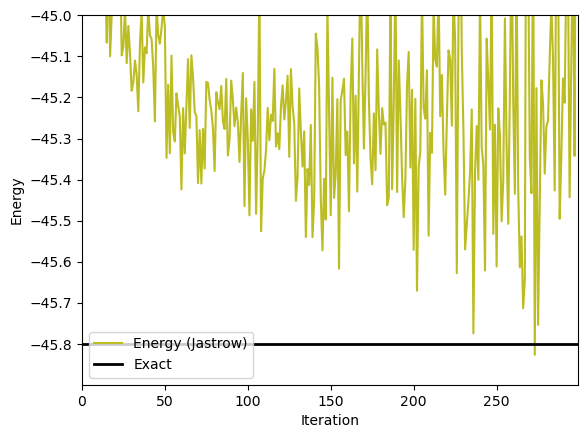

In [8]:
# import the data from log file
data_Jastrow=json.load(open("Jastrow.log"))
   
iters_Jastrow = data_Jastrow["Energy"]["iters"]
energy_Jastrow = data_Jastrow["Energy"]["Mean"]["real"]

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_Jastrow[-1],exact_gs_energy-0.1,exact_gs_energy+0.8])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_Jastrow[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

## RBM

In [9]:
# RBM ansatz with alpha=1
ma = nk.models.RBM(alpha=1)

In [10]:
# Build the sampler
#sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=graph)
sa = nk.sampler.MetropolisLocal(hilbert=hi)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.01)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1000)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(out='RBM', n_iter=600)
end = time.time()

print('### RBM calculation')
print('Has',vs.n_parameters,'parameters')
print('The RBM calculation took',end-start,'seconds')

/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/600 [00:00<?, ?it/s]

### RBM calculation
Has 288 parameters
The RBM calculation took 24.609536170959473 seconds


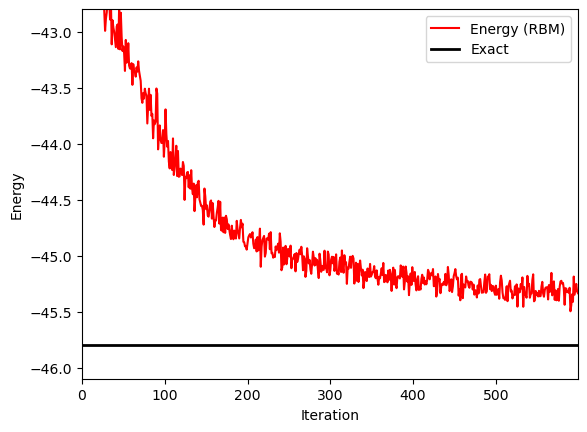

In [11]:
# import the data from log file
data=json.load(open("RBM.log"))
   
# Extract the relevant information
iters_RBM = data["Energy"]["iters"]
energy_RBM = data["Energy"]["Mean"]
    
fig, ax1 = plt.subplots()
ax1.plot(iters_RBM, energy_RBM, color='red', label='Energy (RBM)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_RBM[-1],exact_gs_energy-0.3,exact_gs_energy+3])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

# Expectation values

In [12]:
Szs = sum([nk.operator.spin.sigmaz(hi, i) for i in range(hi.size)])/hi.size
Szcorr = sum([nk.operator.spin.sigmaz(hi, i) * nk.operator.spin.sigmaz(hi, j) for (i, j) in graph.edges()])/len(graph.edges())

In [13]:
def get_expectations(hfield):
    J = 1
    # calling the Heisenberg Hamiltonian
    ha_heisenberg = J * nk.operator.Heisenberg(hilbert=hi, graph=graph)

    # creating the B-field hamiltonian
    ha_hfield = sum([hfield*sigmaz(hi,i) for i in range(hi.size)])
    ha = ha_hfield + ha_heisenberg
    #ha = ha_heisenberg
    # RBM ansatz with alpha=1
    ma = nk.models.RBM(alpha=1)

    # Build the sampler
    #sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=graph)
    sa = nk.sampler.MetropolisLocal(hilbert=hi)

    # Optimizer
    op = nk.optimizer.Sgd(learning_rate=0.01)

    # Stochastic Reconfiguration
    sr = nk.optimizer.SR(diag_shift=0.1)

    # The variational state
    vs = nk.vqs.MCState(sa, ma, n_samples=1000)

    # The ground-state optimization loop
    gs = nk.VMC(
        hamiltonian=ha,
        optimizer=op,
        preconditioner=sr,
        variational_state=vs)

    start = time.time()
    gs.run(out='RBM', n_iter=600)
    end = time.time()

    print('### RBM calculation')
    print('Has',vs.n_parameters,'parameters')
    print('The RBM calculation took',end-start,'seconds')

    vs.n_samples=400000
    Sz_val = vs.expect(Szs)
    Szcorr_val = vs.expect(Szcorr)
    return Sz_val, Szcorr_val

In [14]:
# Range of magnetic field values to explore
hfield_values = np.linspace(-2, 2, 11)
expectation_values = []

# Loop over magnetic field values and compute expectation values
for hfield in hfield_values:
    Sz, SzSz = get_expectations(hfield)
    expectation_values.append((hfield, Sz, SzSz))

# Convert the results to a numpy array for easier handling
expectation_values = np.array(expectation_values)

# Print the results
for (hfield, Sz, SzSz) in expectation_values:
    print(f"hfield={hfield:.2f}, <Sz>={Sz:.6f}, <SzSz>={SzSz:.6f}")

# Optionally, plot the results if you have matplotlib installed
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(expectation_values[:, 0], expectation_values[:, 1], label="<Sz>")
plt.xlabel("hfield")
plt.ylabel("<Sz>")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(expectation_values[:, 0], expectation_values[:, 2], label="<SzSz>")
plt.xlabel("hfield")
plt.ylabel("<SzSz>")
plt.legend()

plt.tight_layout()
plt.show()


/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/600 [00:00<?, ?it/s]

### RBM calculation
Has 288 parameters
The RBM calculation took 19.56562900543213 seconds


/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/600 [00:00<?, ?it/s]

### RBM calculation
Has 288 parameters
The RBM calculation took 20.973685026168823 seconds


/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/600 [00:00<?, ?it/s]

### RBM calculation
Has 288 parameters
The RBM calculation took 21.501081943511963 seconds


/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/600 [00:00<?, ?it/s]

### RBM calculation
Has 288 parameters
The RBM calculation took 21.998592853546143 seconds


/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/600 [00:00<?, ?it/s]

### RBM calculation
Has 288 parameters
The RBM calculation took 20.762625694274902 seconds


/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/600 [00:00<?, ?it/s]

### RBM calculation
Has 288 parameters
The RBM calculation took 23.527220964431763 seconds


/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/600 [00:00<?, ?it/s]

### RBM calculation
Has 288 parameters
The RBM calculation took 27.905725955963135 seconds


/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/600 [00:00<?, ?it/s]

### RBM calculation
Has 288 parameters
The RBM calculation took 21.001364946365356 seconds


/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/600 [00:00<?, ?it/s]

### RBM calculation
Has 288 parameters
The RBM calculation took 23.265511989593506 seconds


/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/600 [00:00<?, ?it/s]

### RBM calculation
Has 288 parameters
The RBM calculation took 23.726089000701904 seconds


/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/600 [00:00<?, ?it/s]

### RBM calculation
Has 288 parameters
The RBM calculation took 32.754359006881714 seconds


TypeError: unsupported format string passed to Stats.__format__


hfield=-2.00, <Sz>=0.151211, <SzSz>=-0.276445

hfield=-1.60, <Sz>=0.120337, <SzSz>=-0.304094

hfield=-1.20, <Sz>=0.088392, <SzSz>=-0.332928

hfield=-0.80, <Sz>=0.028868, <SzSz>=-0.394588

hfield=-0.40, <Sz>=0.006503, <SzSz>=-0.422415

hfield=0.00, <Sz>=0.000048, <SzSz>=-0.415986

hfield=0.40, <Sz>=-0.006292, <SzSz>=-0.423004

hfield=0.80, <Sz>=-0.028770, <SzSz>=-0.396803

hfield=1.20, <Sz>=-0.085870, <SzSz>=-0.336927

hfield=1.60, <Sz>=-0.120035, <SzSz>=-0.305500

hfield=2.00, <Sz>=-0.151146, <SzSz>=-0.274883


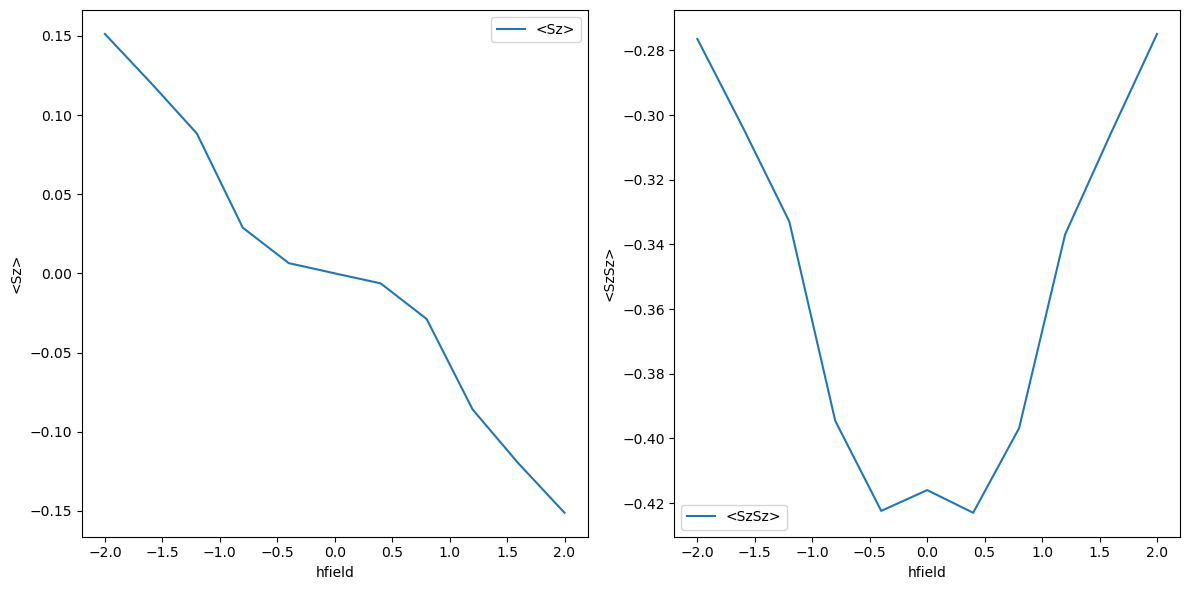

In [28]:
# Print the results
for (hfield, Sz, SzSz) in expectation_values:
    print()
    print(f"hfield={hfield:.2f}, <Sz>={Sz.mean:.6f}, <SzSz>={SzSz.mean:.6f}")

# Optionally, plot the results if you have matplotlib installed
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(expectation_values[:, 0], [expectation_values[i, 1].mean for i in range(len(expectation_values))] , label="<Sz>")
plt.xlabel("hfield")
plt.ylabel("<Sz>")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(expectation_values[:, 0], [expectation_values[i, 2].mean for i in range(len(expectation_values))], label="<SzSz>")
plt.xlabel("hfield")
plt.ylabel("<SzSz>")
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
h

RBM(
    # attributes
    param_dtype = float64
    activation = log_cosh
    alpha = 1
    use_hidden_bias = True
    use_visible_bias = True
    precision = None
    kernel_init = init
    hidden_bias_init = init
    visible_bias_init = init
)